In [3]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from copy import copy

from utils.conn_data import load_pickle

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [7]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "src", 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = [
    # "lasso1_nocluster",
    # "pairwise-granger_nocluster",
    # "multivariate-granger_nocluster",
    "dynotears_rollingcluster_k5",
    "dynotears_cluster_k5",
    "var-lingam_rollingcluster_k5",
    "var-lingam_cluster_k5",
]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [8]:
all_parents = []
for fs in fs_methods:
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]
        obj = load_pickle(path=file)
        parents_of_target_df = obj["parents_of_target"]

        # add tags
        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        # fill na of clusters column
        if (fs == "dynotears_rollingcluster_k5") or (fs == "var-lingam_rollingcluster_k5"):
            parents_of_target_df["cluster"] = parents_of_target_df["cluster"].fillna(parents_of_target_df["cluster"].max() + 1)
        elif (fs == "lasso1_nocluster") or (fs == "pairwise-granger_nocluster") or (fs == "multivariate-granger_nocluster"):
            parents_of_target_df['cluster'] = pd.factorize(parents_of_target_df['fred'])[0]

        all_parents.append(parents_of_target_df)
all_parents_df = pd.concat(all_parents)

## Parents over time

<AxesSubplot:xlabel='None-cluster', ylabel='date'>

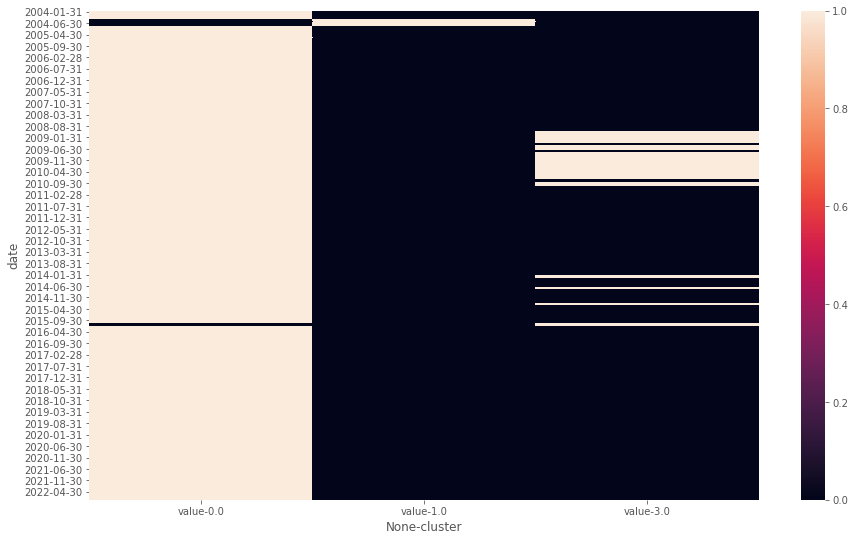

In [9]:
etf = "SPY"
fs = "var-lingam_cluster_k5"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(15, 9))
sns.heatmap(check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

<AxesSubplot:xlabel='None-cluster', ylabel='date'>

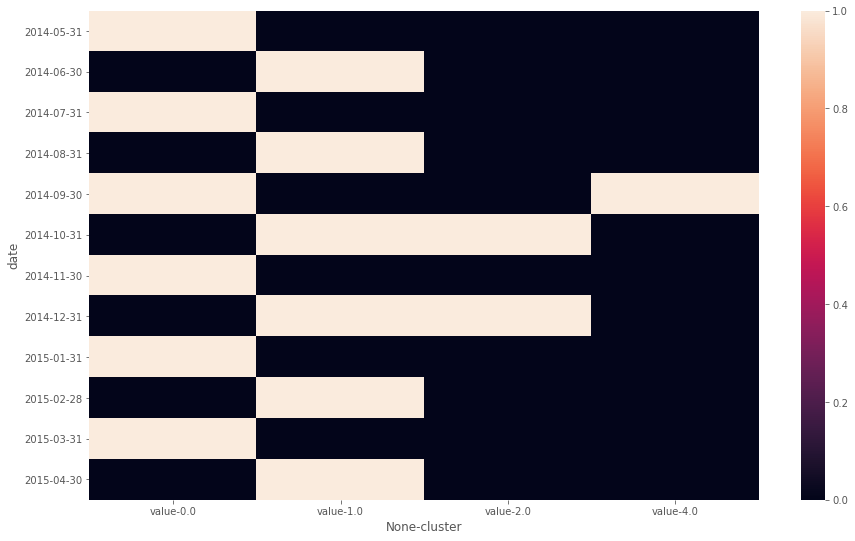

In [15]:
etf = "SPY"
fs = "var-lingam_rollingcluster_k5"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(15, 9))
sns.heatmap(check_df.loc[(check_df["date"] >= "2014-05-01")&(check_df["date"] <= "2015-05-01")].pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

<AxesSubplot:xlabel='date'>

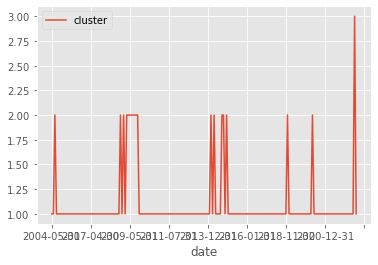

In [25]:
check_df.groupby(["date"]).count()[["cluster"]].plot()

## Average Number of Parents

In [44]:
avgs = []
for fs in all_parents_df["fs"].unique():
    for etf in all_parents_df["etf"].unique():
        check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)

        mean = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).mean()
        std = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).std()
        skew = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).skew()

        avgs.append({"fs": fs, "etf": etf,
                     "mean": mean if not pd.isna(mean) else 0,
                     "std": std if not pd.isna(std) else 0,
                     "skew": skew if not pd.isna(skew) else 0})
avgs_df = pd.DataFrame(avgs)

In [45]:
avgs_df.sort_values(by=["mean"], ascending=False)[["fs", "etf", "mean", "std"]]

,fs,etf,mean,std
26,multivariate-granger_nocluster,XLB,28.423358,29.149897
25,multivariate-granger_nocluster,XLU,27.792857,29.635313
21,multivariate-granger_nocluster,XLK,27.683453,28.808220
29,multivariate-granger_nocluster,XLI,27.648855,30.139400
28,multivariate-granger_nocluster,XLP,25.773050,30.592802
23,multivariate-granger_nocluster,SPY,25.064748,27.499989
24,multivariate-granger_nocluster,XLY,24.604478,31.685252
27,multivariate-granger_nocluster,XLV,24.333333,27.825927
20,multivariate-granger_nocluster,XLE,24.029851,29.513586
12,pairwise-granger_nocluster,XLF,23.757709,11.723902


## New Stability measure

In [46]:
all_etfs_scores = []
all_avg_scores = []
for ticker in all_parents_df["etf"].unique():
    etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
    etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

    etf_df = etf_df.sort_values(by=["date"])
    all_scores = []
    for fs in etf_df["fs"].unique():
        fs_etf_df = etf_df[etf_df["fs"] == fs]

        score = []
        for i, date in enumerate(fs_etf_df["date"].unique()):
            if i == 0:
                F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = 0
            else:
                F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else np.nan
                F_tm1 = copy(F_t)
            score.append({"date": date, "score": s})
        score_df = pd.DataFrame(score)
        score_df["fs"] = fs

        melt_score_df = score_df.melt(["date", "fs"])
        all_scores.append(melt_score_df)
    all_scores_df = pd.concat(all_scores).drop("variable", axis=1)
    all_scores_df["etf"] = ticker
    all_etfs_scores.append(all_scores_df)

    avg_scores = all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False).reset_index()
    avg_scores['ticker'] = ticker
    avg_scores = avg_scores[['ticker', 'fs', 'value']]
    all_avg_scores.append(avg_scores)
all_avg_scores_df = pd.concat(all_avg_scores)
all_etfs_scores_df = pd.concat(all_etfs_scores)

### (a) Stability Measure over time

<AxesSubplot:xlabel='date'>

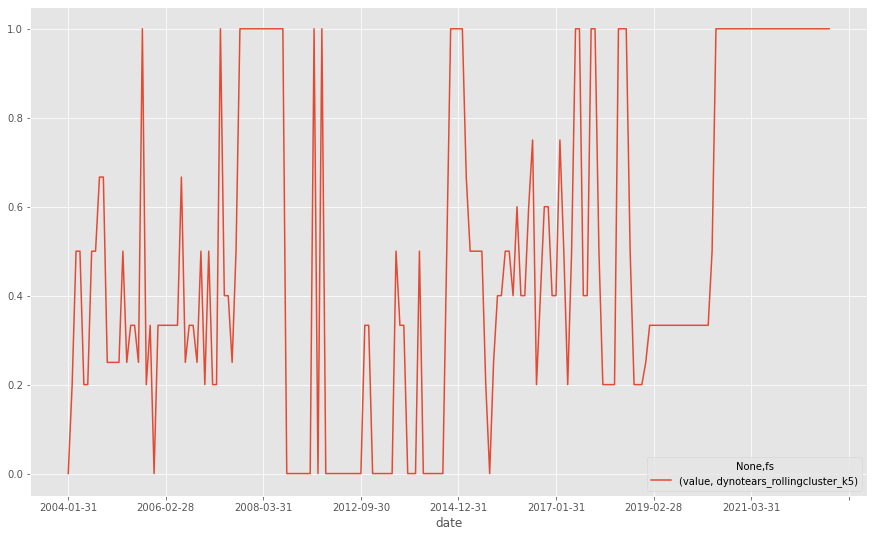

In [47]:
all_etfs_scores_df.loc[(all_etfs_scores_df["etf"] == "SPY")&(all_etfs_scores_df["fs"] == "dynotears_rollingcluster_k5")].pivot_table(index=["date"], columns=["fs"], values=["value"]).plot(figsize=(15, 9))

In [24]:
all_etfs_scores_df.loc[""]

,date,fs,value,etf
0,2004-01-31,pairwise-granger_nocluster,0.000000,XLE
1,2004-02-29,pairwise-granger_nocluster,0.714286,XLE
2,2004-03-31,pairwise-granger_nocluster,1.000000,XLE
3,2004-04-30,pairwise-granger_nocluster,1.000000,XLE
4,2004-05-31,pairwise-granger_nocluster,0.800000,XLE
...,...,...,...,...
126,2022-07-31,multivariate-granger_nocluster,1.000000,XLI
127,2022-08-31,multivariate-granger_nocluster,0.727273,XLI
128,2022-09-30,multivariate-granger_nocluster,0.750000,XLI
129,2022-10-31,multivariate-granger_nocluster,0.769231,XLI


### (b) Average Stability Measure

In [37]:
all_etfs_scores_df.drop(["date"], axis=1).groupby(["etf", "fs"]).mean().sort_values(by=["value"], ascending=False)

,,value
etf,fs,
XLB,pairwise-granger_nocluster,0.943770
XLV,pairwise-granger_nocluster,0.940831
XLI,pairwise-granger_nocluster,0.940492
XLY,pairwise-granger_nocluster,0.926985
SPY,pairwise-granger_nocluster,0.924644
XLF,pairwise-granger_nocluster,0.922648
XLK,pairwise-granger_nocluster,0.901165
XLE,pairwise-granger_nocluster,0.898524
XLP,pairwise-granger_nocluster,0.894225
